## Pairs Trading Strategy on XBTUSD ( Perpetual Swap ) and XBTZ19 ( Futures Contract )

    The idea is to open a hedge across the XBTUSD perpetual swap and a XBT futures contract. In the below implementation XBTZ19 is the futures contract. As the futures price changes in comparison to the XBTUSD price the profit and loss changes over both positions.
    In this implementation the spread is XBTZ19 - XBTUSD. The spread should go down to 0 becasue the futures price will always expire at the same price as spot in the futures market.
    The futures contract price is always trades between a premium and discount to the perpetual XBTUSD price.
    If you are long XBTZ19 Futures and short XBTUSD then you want the futures price to move further away from the XBTUSD price.
    If you are short XBTZ19 futures and long XBTUSD then you want the futures price to move closer to the XBTUSD price.    

In [86]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
from scipy import stats
import statsmodels.api as sm
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Data
    Below I have fetched the minute level data of the perpetual swap and futures contract(xbtz19).The data of xbtz19 is  available from June 14, 2019. Also the prices obtained are volume weighted average prices sourced from bitmex.

In [87]:
xbtz19 = pd.read_csv('xbtz19_df_1m.csv', usecols = ['timestamp','vwap'])
xbtusd = pd.read_csv('xbtusd_df_1m.csv', usecols = ['timestamp','vwap'])
funding_rates = pd.read_csv('funding_rates_df.csv', usecols = ['timestamp','fundingRate'])
xbtz19.columns = ['timestamp','vwap_futures']
xbtusd.columns = ['timestamp','vwap_swap']

In [88]:
funding_rates.set_index('timestamp', inplace = True)
funding_rates = funding_rates.loc['2019-06-14 08:31:00+00:00':] 
funding_rates.head()

,fundingRate
timestamp,
2019-06-14 12:00:00+00:00,0.000100
2019-06-14 20:00:00+00:00,0.000100
2019-06-15 04:00:00+00:00,-0.000116
2019-06-15 12:00:00+00:00,0.000100
2019-06-15 20:00:00+00:00,0.000211


In [89]:
xbtz19.head()

,timestamp,vwap_futures
0,2019-06-14 08:31:00+00:00,0.0000
1,2019-06-14 08:32:00+00:00,0.0000
2,2019-06-14 08:33:00+00:00,8262.4143
3,2019-06-14 08:34:00+00:00,8325.0083
4,2019-06-14 08:35:00+00:00,8322.9297


In [90]:
xbtz19.set_index('timestamp', inplace = True)
xbtusd.set_index('timestamp', inplace = True)
xbtz19.index = pd.to_datetime(xbtz19.index)
xbtusd.index = pd.to_datetime(xbtusd.index)
xbtz19 = xbtz19[xbtz19.vwap_futures != 0]

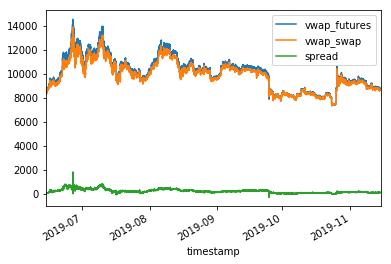

In [91]:
a = xbtz19.join(xbtusd, how = 'inner')
a['spread'] = a['vwap_futures'] - a['vwap_swap']
a.plot()
plt.legend()
plt.show()

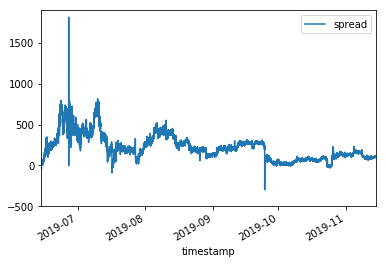

In [92]:
a['spread'].fillna(method = 'bfill', inplace = True)
a['spread'].plot()
plt.ylim(-500,1900)
plt.legend()
plt.show()

### Entry levels for spread trade
    Below I have used a roliing window for computing mean and standard deviation to take into account the different spread regimes.

In [93]:
a['u'] = a['spread'].rolling(200).mean().fillna(method = 'bfill')
a['g'] = a['spread'].rolling(200).std().fillna(method = 'bfill')
a['level_up'] = a['u'] + 1.5 * a['g']
a['level_down'] = a['u'] - 1.5 * a['g']
a.head()

,vwap_futures,vwap_swap,spread,u,g,level_up,level_down
timestamp,,,,,,,
2019-06-14 08:33:00+00:00,8262.4143,8302.2001,-39.7858,55.048315,11.494613,72.290235,37.806395
2019-06-14 08:34:00+00:00,8325.0083,8296.6896,28.3187,55.048315,11.494613,72.290235,37.806395
2019-06-14 08:35:00+00:00,8322.9297,8292.5616,30.3681,55.048315,11.494613,72.290235,37.806395
2019-06-14 08:36:00+00:00,8317.5000,8293.2493,24.2507,55.048315,11.494613,72.290235,37.806395
2019-06-14 08:37:00+00:00,8328.0000,8294.6251,33.3749,55.048315,11.494613,72.290235,37.806395


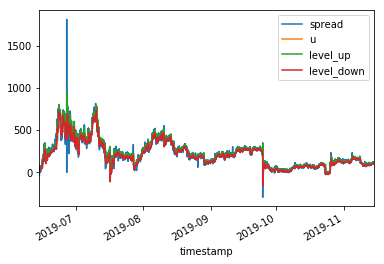

In [94]:
a[['spread','u','level_up','level_down']].plot()

### Hedge Ratio Computation

    Below I have regressed the futures prices on the swap prices to calculate the hedge ratio.

In [95]:
a.dropna(axis = 0, how = 'any', inplace = True)
mean_f = a['vwap_futures'].mean()
std_f = a['vwap_futures'].std()
mean_s = a['vwap_swap'].mean()
std_s = a['vwap_swap'].std()
y = np.array((a['vwap_futures'] - mean_f)/std_f)
X = np.array((a['vwap_swap'] - mean_s)/std_s)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 6.435e+07
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:47:14   Log-Likelihood:             2.9060e+05
No. Observations:              196617   AIC:                        -5.812e+05
Df Residuals:                  196615   BIC:                        -5.812e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.454e-13      0.000  -5.19e-09      1.000      -0.000       0.000
x1             0.9985      0.000   8021.638      0.000       0.998       0.999
==============================================================================
Omnibus:                    65833.736   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           385857.422
Skew:                           1.493   Prob(JB):                         0.00
Kurtosis:                       9.179   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion from the above regression

    As we can see the coefficent of swap prices is almost 1, so we can use a hedge ratio of one.

### Co-integration Test
    Spread = futures – n * swap where n is the hedge ratio
    n = 1 from the above regression

In [96]:
cadf = ts.adfuller(a['spread'])
print('Augmented Dickey Fuller test statistic =',cadf[0])
print('Augmented Dickey Fuller p-value =',cadf[1])
print('Augmented Dickey Fuller 1%, 5% and 10% test statistics =',cadf[4])

Augmented Dickey Fuller test statistic = -3.1871981352030034
Augmented Dickey Fuller p-value = 0.020737763310191913
Augmented Dickey Fuller 1%, 5% and 10% test statistics = {'1%': -3.4303832732192134, '5%': -2.861554706321204, '10%': -2.5667778276462965}


### Conclusion from ADF Test

    The above results indicate that the spread time series is stationary.

### Half life

    Half life indicates how long the spread typically takes to revert back to the mean.

In [12]:
spread_lag = a["spread"].shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]
spread_ret = a["spread"] - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]
spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret,spread_lag2)
res = model.fit()
hl = round(-np.log(2) / res.params[1],1)

print('Halflife in minutes = ',hl)

Halflife in minutes =  643.5


### Strategy
    
    Spread Trading Strategy Function ( function arguments -funding_rates, a-prices data frame,g_multiple, j_multiple, s, M graph)
    1) g_multiple is the number of standarad deviations away from the mean are the extreme levels for deciding entry and exit points. Assume a short position in the spread if the spread is more than (mean + g_multiple*standard_deviation) and a long position if the return spread is below the (mean - g_multiple * standard_deviation).

    2) j_multiple is used for determining the exit criteria from the position already taken in the market.These levels are smaller than the entry levels so I have used j_multiple as a value lesser than 1 so that j_levels are lower than g levels. (mean + j_multiple * g_multiple * standard_deviation) for exiting the short positions and ((mean - j_multiple * g_multiple*standard_deviation) for exiting the long position.

    3) s is the stop loss parameter. So in case if we are long spread and the spread goes below (mean - s * standard_deviation) then we hit a stop loss and exit the long position whereas if we are short spread and the spread goes above (mean + s * standard_deviation) then wen hit a stop loss and close the short spread position.

    4) M is the number of minutes used for calculating the rolling mean and standard deviation.
    
    5) I am using default contract quantity of 1000 contracts for both futures and swaps. This thing can be changed dynamically and made a variable contract depending on how strong the signal is.
    
    6) In the below implementation I always trade one contract of swap and future each. So the fees calulations and the funding receipts calculation all take one contract into account. 
    
    7) In the fees calculation I have assumed that we pay the taker fees(7.5bps) for perpetual swap and receive maker fees(2.5 bps) in futures contract because futures is more illiquid.
    
    8) Funding gain/loss is computed using the funding rate time series for the period and keeping one contract in mind.
    9) Position_Value of one contract at a particular time is 1/Price.
    10) Fees is computed using the below calculation
            Fees = (0.075 - 0.025)/100 * Position_Value
    11) Funding gain/loss is computed as follows,
            Funding gain/loss = funding rate * Position_Value

In [72]:
def spread_trade(funding_rates,a,M,g,j,s, contract_quantity = 1000, graph = 0):
    
    df = a.copy()
    df = df[['vwap_futures','vwap_swap','spread']]
    
    df['u'] = df['spread'].rolling(M).mean().fillna(method = 'bfill')
    df['g'] = df['spread'].rolling(M).std().fillna(method = 'bfill')
    df['j'] = j * df['g']
    df['level_up_entry'] = df['u'] + g * df['g']
    df['level_up_exit'] = df['u'] + g * df['j']
    df['level_down_entry'] = df['u'] - g * df['g']
    df['level_down_exit'] = df['u'] - g * df['j']
    
    df["Position"] = 0 * len(df["spread"])
    df['futures:Position'] = 0 * len(df["spread"])
    df['swap:Position'] = 0 * len(df["spread"])
    df["StopLoss"] = 0 * len(df["spread"])
    df["StopLoss_Level"] = 0.0 * len(df["spread"])
    
    flag,stop_loss = 0,0
    future_traded_price,swap_traded_price = 0,0
    future_qty,swap_qty = 0,0
    stop_loss_level = 0
    
    for i in range(0,len(df.index)):
        
        stop_loss  = 0

        if (((df.iat[i,2] < stop_loss_level) & (i != 0) & (flag == 1)) | \
            ((df.iat[i,2] > stop_loss_level) & (i != 0) & (flag == -1))):
            
            stop_loss = 1
            flag = 0
            future_qty,swap_qty,stop_loss_level = 0,0,0
            
        if (stop_loss != 0):                                       
            
            df.iat[i,10] = flag                                                                        #["Position"]
            df.iat[i,11] = future_qty                                                          #["futures:Position"]
            df.iat[i,12] = swap_qty                                                               #["swap:Position"]
            df.iat[i,13] = stop_loss
            df.iat[i,14] = stop_loss_level
            
            continue
    
        if (df.iat[i,2] > df.iat[i,6] and flag != -1):                             #short spread means short-flag=-1
            
            flag = -1
            future_qty = - 1 * contract_quantity
            swap_qty = + 1 * contract_quantity
            future_traded_price = 1/df.iat[i,0]
            swap_traded_price = 1/df.iat[i,1]
            stop_loss_level = df.iat[i,3] + s * df.iat[i,4]
            
        if (df.iat[i,2] < df.iat[i,7] and flag == -1):                              #exit point for short-sell spread
            
            flag = 0
            future_qty,swap_qty,stop_loss_level = 0,0,0
            
        if (df.iat[i,2] < df.iat[i,8] and flag != 1):                                 #long spread means buy flag = 1
            
            flag = 1
            future_qty = 1 * contract_quantity
            swap_qty = - 1 * contract_quantity
            future_traded_price = 1/df.iat[i,0]
            swap_traded_price = 1/df.iat[i,1]
            stop_loss_level = df.iat[i,3] - s * df.iat[i,4] 
            
        if (df.iat[i,2] > df.iat[i,9] and flag == 1):                               #exit point for buy-long spread
            
            flag = 0
            future_qty,swap_qty,stop_loss_level = 0,0,0
        
        df.iat[i,10] = flag                                                         #updating the ["Position"] column
        df.iat[i,11] = future_qty                                            #updating the ["future:Position"] column
        df.iat[i,12] = swap_qty                                                #updating the ["swap:Position"] column
        df.iat[i,13] = stop_loss                                                    #updating the ['StopLoss'] column
        df.iat[i,14] = stop_loss_level                                        #updating the ['StopLoss_Level'] column
        
    df['Trade_Type'] = df.iloc[:,10] - df.iloc[:,10].shift(1).fillna(0)
    df['future:Traded'] = df.iloc[:,11] - df.iloc[:,11].shift(1).fillna(0)
    df['swap:Traded'] = df.iloc[:,12] - df.iloc[:,12].shift(1).fillna(0)
    df["Position_Value"] = (df.iloc[:,17] * 1/df.iloc[:,1] + df.iloc[:,16] * 1/df.iloc[:,0])
    df['PnL_C'] = df.iloc[:,18].cumsum()
    df["Entry"] = df.iloc[:,15].where(df.iloc[:,15] == 1)
    df["Exit"] = -1 * df.iloc[:,15].where(df.iloc[:,15] == -1)
    df["Entry_after_Exit"] = 1/2 * df.iloc[:,15].where(df.iloc[:,15] == 2)
    df["Exit_after_Entry"] = -1/2 * df.iloc[:,15].where(df.iloc[:,15] == -2)
    df['SL_Flag'] = (df.iloc[:,13] - df.iloc[:,13].shift(1).fillna(0))
    df['SL_Flag'] = df['SL_Flag'].where(df['SL_Flag'] == 1)
    df['Fees'] = 0 * len(df.index)
    df.loc[df['Trade_Type'] != 0,'Fees']  = np.abs(df['Position_Value'])*(-(0.025/100) + (0.075/100))
    
    
    funding_rates = funding_rates.shift(1)               # Actual Funding rate paid at a particular 8 - hour period is 
                                                                                         #fixed in the previous period
    df = df.join(funding_rates, how = 'outer')
    
    df['funding_gain/loss'] = 0.0 * len(df['spread'])
    df['Net PnL_C'] = 0.0 * len(df['spread'])
    df.loc[(df['fundingRate'] > 0) & df['swap:Position'] == 1,'funding_gain/loss'] = - df.fundingRate * df.Position_Value
    df.loc[(df['fundingRate'] < 0) & df['swap:Position'] == 1,'funding_gain/loss'] = df.fundingRate * df.Position_Value
    df.loc[(df['fundingRate'] > 0) & df['swap:Position'] == -1,'funding_gain/loss'] = df.fundingRate * df.Position_Value
    df.loc[(df['fundingRate'] < 0) & df['swap:Position'] == -1,'funding_gain/loss'] = -df.fundingRate * df.Position_Value
    df['Net PnL_C'] = (df['Position_Value'] - df['Fees'] + df['funding_gain/loss']).cumsum()
    
    if graph == 1:
        
        graph_f(df)
    
    return df.iat[-1,19]

In [73]:
def graph_f(df):
    
        print("Stop Loss Hit ",df['SL_Flag'].sum(),' times')
        print("Total Positions entered ",0.5*(df.iloc[:,20].sum() + abs(df.iloc[:,21].sum())
                                         + 2 * df.iloc[:,22].sum() + 2 * abs(df.iloc[:,23].sum()))," times")
        
        print("Total times traded ",(df.iloc[:,20].sum() + abs(df.iloc[:,21].sum())
                                         + 2 * df.iloc[:,22].sum() + 2 * abs(df.iloc[:,23].sum()))," times")
        print("Net Pnl is ",df.iat[-1,28],'XBT')
        print("\n")
        
        plt.plot(df.index,df['PnL_C'])
        plt.plot(df.index,df['Net PnL_C'])
        plt.legend()
        
        plt.subplots(figsize = (50,16))
        plt.plot(df.index,df['spread'])
        plt.plot(df.index,df['Entry_after_Exit'] * df['spread'],'ro',color = "green",markersize = 20,
                 label = "Buying Spread after Selling")
        plt.plot(df.index,df['Exit_after_Entry'] * df['spread'],'ro',color = "red",markersize = 20,
                 label = "Selling Spread after Buying")
        plt.plot(df.index,df['Entry'] * df['spread'],'ro',color = "green",markersize = 10,label = "Buying Spread")
        plt.plot(df.index,df['Exit'] * df['spread'],'ro',color = "red",markersize = 10,label = "Selling Spread")
        plt.plot(df.index,df['SL_Flag'] * df['spread'],'*',color = "black",markersize = 10,label = "Stop Loss")
        
        x_min,x_max = df.index[0],df.index[-1]
        plt.legend(loc = 'upper left')
        plt.plot(df.index, df['level_up_entry'], label = "Entry Level up")
        plt.plot(df.index, df['level_up_exit'], label = "Exit Level up")
        plt.plot(df.index, df['level_down_entry'], label = "Entry Level down")
        plt.plot(df.index, df['level_down_exit'], label = "Exit Level down")
        plt.xlabel("Dates")
        plt.ylabel("Spread")
        
        plt.title("Spread Trading (swap - futures) Net Pnl = %0.4f XBT"%df.iat[-1,28],fontsize = 30)
        plt.tight_layout()
        plt.show()

### Hyperparameters Tuning
    
    Below I have run the spread trade strategy using a few set of values for the rolling mean and standard deviation period (M). The multipliers for standard deviation exit and entry and few values for stop loss. The values of s are multiples of standard deviation.
    
    I am trying only a few values for j (0.6,0.7,0.8), these are the multipliers for g value, also the fact that I just go up to 0.8 times g is because the difference should be atleast a dollar(2 ticks) to enter and exit a trade. 

In [81]:
temp = []

for M in [200,300,400]:                                                                                 
    for g in [0.5,1,1.5]:                                                                               
        for j in [0.6,0.7,0.8]:                                                                           
            for s in [3,4,5]:
                z = spread_trade(funding_rates,a, M, g, j, s,1000,0)
                temp.append([M,g,j,s,z])

results = pd.DataFrame(temp,columns = ["M","g","j","s","Pnl"])                
results['j'] = np.round(results['j'],3)
results['g'] = np.round(results['g'],3)
results['s'] = np.round(results['s'],4)

In [82]:
print("Top 20 PNL generating combinations are:")
print(results.sort_values("Pnl",ascending = False).head(20))

Top 20 PNL generating combinations are:
      M    g    j  s       Pnl
8   200  0.5  0.8  5  1.127172
5   200  0.5  0.7  5  1.111524
7   200  0.5  0.8  4  1.093738
2   200  0.5  0.6  5  1.090516
4   200  0.5  0.7  4  1.078769
1   200  0.5  0.6  4  1.058030
17  200  1.0  0.8  5  1.006738
6   200  0.5  0.8  3  1.001000
3   200  0.5  0.7  3  0.985798
14  200  1.0  0.7  5  0.979956
35  300  0.5  0.8  5  0.978853
16  200  1.0  0.8  4  0.977676
0   200  0.5  0.6  3  0.966934
32  300  0.5  0.7  5  0.962876
34  300  0.5  0.8  4  0.953292
11  200  1.0  0.6  5  0.952279
13  200  1.0  0.7  4  0.950211
29  300  0.5  0.6  5  0.943211
31  300  0.5  0.7  4  0.938256
10  200  1.0  0.6  4  0.921934


In [83]:
results.to_csv("results.csv")

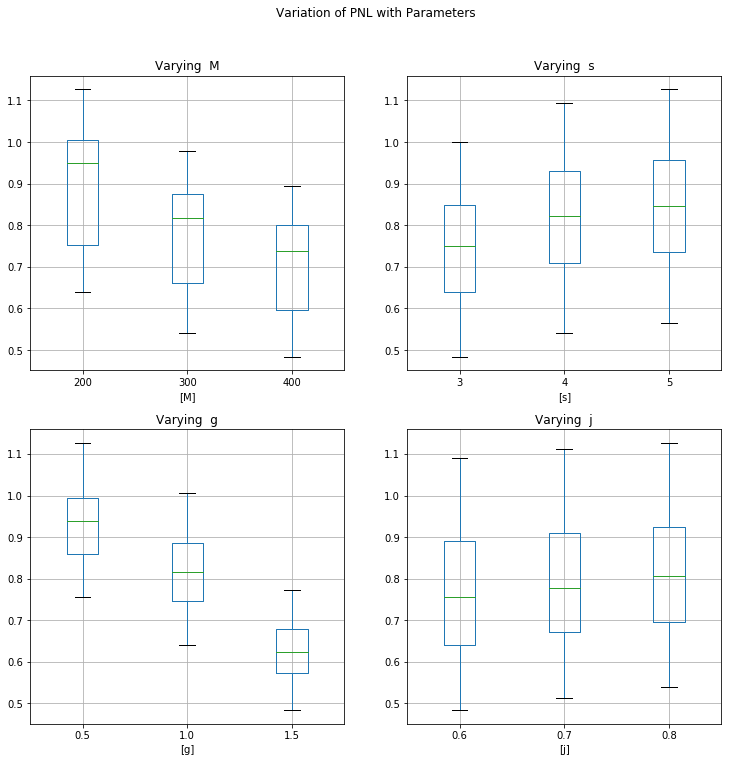

In [84]:
f, ax = plt.subplots(2, 2,figsize = (12,12))
results.boxplot(column = ['Pnl'],by=['M'],ax = ax[0][0])
ax[0][0].title.set_text("Varying  M")
results.boxplot(column = ['Pnl'],by = ['s'],ax = ax[0][1])
ax[0][1].title.set_text("Varying  s")
results.boxplot(column = ['Pnl'],by = ['g'],ax = ax[1][0])
ax[1][0].title.set_text("Varying  g")
results.boxplot(column = ['Pnl'],by = ['j'],ax = ax[1][1])
ax[1][1].title.set_text("Varying  j")
f.suptitle("Variation of PNL with Parameters")
plt.show()

### Conclusion from the hyperparameters tuning

    As we can see from the above box plot and the list of parameters which provide the highest gains are:
    M = 200, g_multiple = 0.5, j_multiple = 0.8 and s = 5

Stop Loss Hit  470.0  times
Total Positions entered  19841.5  times
Total times traded  39683.0  times
Net Pnl is  1.0885104145712807 XBT




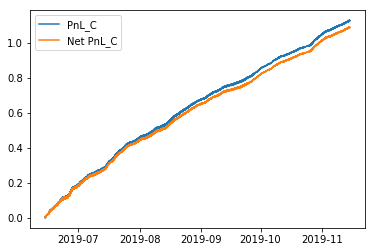

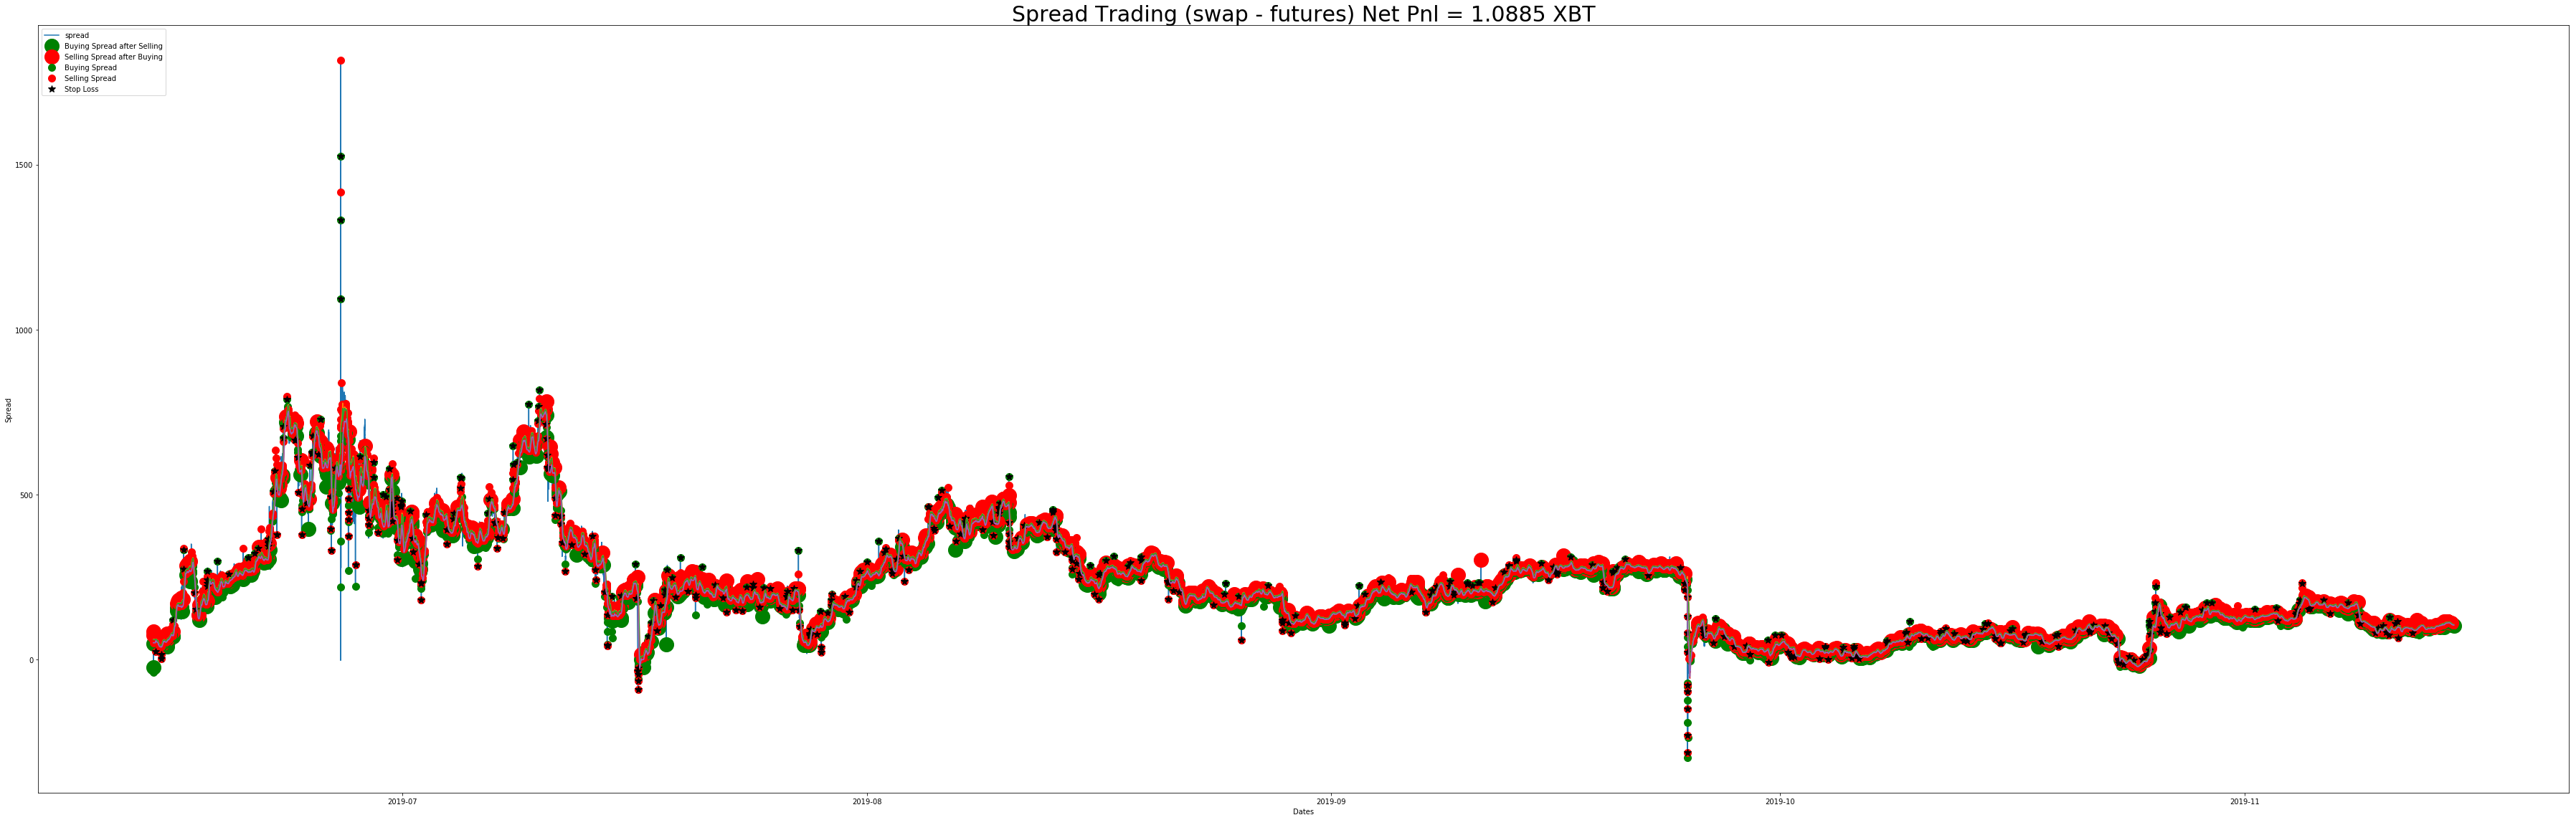

1.1271717548521063

In [85]:
spread_trade(funding_rates,a,200,0.5,0.80,5,contract_quantity = 1000, graph = 1)

In [25]:
def max_drawdown(returns):
    
    local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
       ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 

    local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
            (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]

    def next_local_min(n):
        if [m for m in local_min if m > n]:
            return [m for m in local_min if m > n][0]
        else: return None

    drawdowns = [(n,next_local_min(n)) for n in local_max]
    drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
    
    if drawdown_values:
        return  np.max(drawdown_values)
    else: return 0.0

In [26]:
max_drawdown(k['PnL_C'])

1524.4501